In [1]:
import glob
import eigsep_observing.io as io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec
import os
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
from hera_filters.dspec import dpss_operator, fit_solution_matrix
import h5py
import json
import healpy as hp
from healpy.sphtfunc import Alm
from scipy.special import sph_harm

%matplotlib widget

In [2]:
def imshow(ax, data, mode='log', vmax=3, vmin=-2, aspect='auto', interpolation='nearest', cmap='plasma'):
    if mode.lower().startswith('log'):
        data = np.log10(np.abs(data))
    elif mode.lower().startswith('abs'):
        data = np.abs(data)
    elif mode.lower().startswith('angle'):
        data = np.angle(data)
        vmax, vmin = np.pi, -np.pi
    return ax.imshow(data, vmax=vmax, vmin=vmin, aspect=aspect, interpolation=interpolation, cmap=cmap)

In [3]:
def plot_time_freq_layout(image, U, Vt, S, neig=None, cmap="plasma", vmin=None, vmax=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(
        2, 2, figure=fig,
        height_ratios=[4, 1],
        width_ratios=[6, 2],
    )

    ax_img  = fig.add_subplot(gs[0, 0])
    ax_f    = fig.add_subplot(gs[1, 0], sharex=ax_img)
    ax_t    = fig.add_subplot(gs[0, 1], sharey=ax_img)
    ax_eig = fig.add_subplot(gs[1, 1])

    im = imshow(ax_img, image, vmin=vmin, vmax=vmax, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_img, orientation="vertical", pad=0.02)

    ax_t.plot(U[:, :neig], np.arange(U.shape[0]))
    ax_f.plot(Vt[:neig].T)
    ax_eig.plot(S[:neig])
    ax_eig.set_yscale("log")

In [4]:
def read_header(fname, keys=None):
    with h5py.File(fname, "r") as f:
        header_grp = f["header"]
        header = {k: v for k, v in header_grp.attrs.items() if keys is None or k in keys}
        for name, obj in header_grp.items():
            if keys is not None and name not in keys:
                continue
            if isinstance(obj, h5py.Group):
                header[name] = {k: v for k, v in obj.attrs.items()}
            else:
                header[name] = json.loads(obj[()])
    return header

mtn_tzone = ZoneInfo("America/Denver")

def unix_time_to_local(unix_times):
    local_times = np.array([datetime.fromtimestamp(ts, tz=timezone.utc).astimezone(mtn_tzone) for ts in unix_times])
    return local_times

dtype_r = np.float32
dtype_c = np.complex64

In [5]:
# noise drop-out features
# start around 7/20 @ 2:05a
noise_dropout_times = [
    (1752826741 - 4, 1752826741 + 240),
    (1752829296 - 4, 1752829296 + 239),
    (1752836820 - 4, 1752836820 + 240),
    (1752839293 - 4, 1752839293 + 244),
    (1752847809 - 4, 1752847809 + 239),
    
    (1752849929 - 4, 1752849929 + 239),
    # swapped inputs
    (1752998738 - 4, 1752998738 + 239),
    (1753002924 - 4, 1753002924 + 239),
    (1753006892 - 4, 1753006892 + 266),
    (1753008681 - 4, 1753008681 + 239),
    
    (1753010172 - 4, 1753010172 + 240),
    (1753011706 - 4, 1753011706 + 257),
    (1753013096 - 4, 1753013096 + 240), # load switched in 
    (1753014466 - 4, 1753014466 + 240),
    (1753016215 - 4, 1753016215 + 240),
    
    (1753017894 - 4, 1753017894 + 239),
    (1753019562 - 4, 1753019562 + 248),
    (1753021191 - 4, 1753021191 + 239),
    (1753023264 - 4, 1753023264 + 241),
]
# ends around 7/20 @ 9:40a
times = np.load('all_ant_2.npz')['times']
local_times = np.load('all_ant_2.npz', allow_pickle=True)['local_times']
noise_dropout_slices = [slice(np.searchsorted(times, t_i), np.searchsorted(times, t_j)+1) for (t_i, t_j) in noise_dropout_times]
noise_dropout_times = [times[sl] for sl in noise_dropout_slices]
noise_dropout_local_times = [local_times[sl] for sl in noise_dropout_slices]

In [6]:
ants = '0234'
npz_files = [f'all_ant_{k}.npz' for k in ants]
noise_dropout_data = {}
for npz_file in npz_files:
    npz = np.load(npz_file, allow_pickle=True)
    freqs = npz['freqs']
    d = {k: npz[k] for k in npz.files if len(k) == 1}
    noise_dropout_data.update({k: [v[sl] for sl in noise_dropout_slices] for k, v in d.items()})
d2, d4 = noise_dropout_data.pop('2'), noise_dropout_data.pop('4')
noise_dropout_data['2'] = d2[:6] + d4[6:] # swap ground & sky antenna
noise_dropout_data['4'] = d4[:6] + d2[6:] # swap ground & sky antenna

In [7]:
#date_range = (datetime(2025, 7, 18, 14, 0, tzinfo=mtn_tzone), datetime(2025, 7, 18, 15, 0, tzinfo=mtn_tzone))
date_range = (datetime(2025, 7, 18, 22, 45, tzinfo=mtn_tzone), datetime(2025, 7, 19, 0, 10, tzinfo=mtn_tzone))
inds = np.where(np.logical_and(local_times > date_range[0], local_times < date_range[-1]))[0]
ants = '012345'
npz_files = [f'all_ant_{k}.npz' for k in ants]
something_data = {}
for npz_file in npz_files:
    npz = np.load(npz_file, allow_pickle=True)
    freqs = npz['freqs']
    d = {k: npz[k] for k in npz.files if len(k) == 1}
    something_data.update({k: v[inds] for k, v in d.items()})
#d2, d4 = something_data.pop('2'), something_data.pop('4')
#something_data['2'] = d2[:6] + d4[6:] # swap ground & sky antenna
#something_data['4'] = d4[:6] + d2[6:] # swap ground & sky antenna

/tmp/ipykernel_65954/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


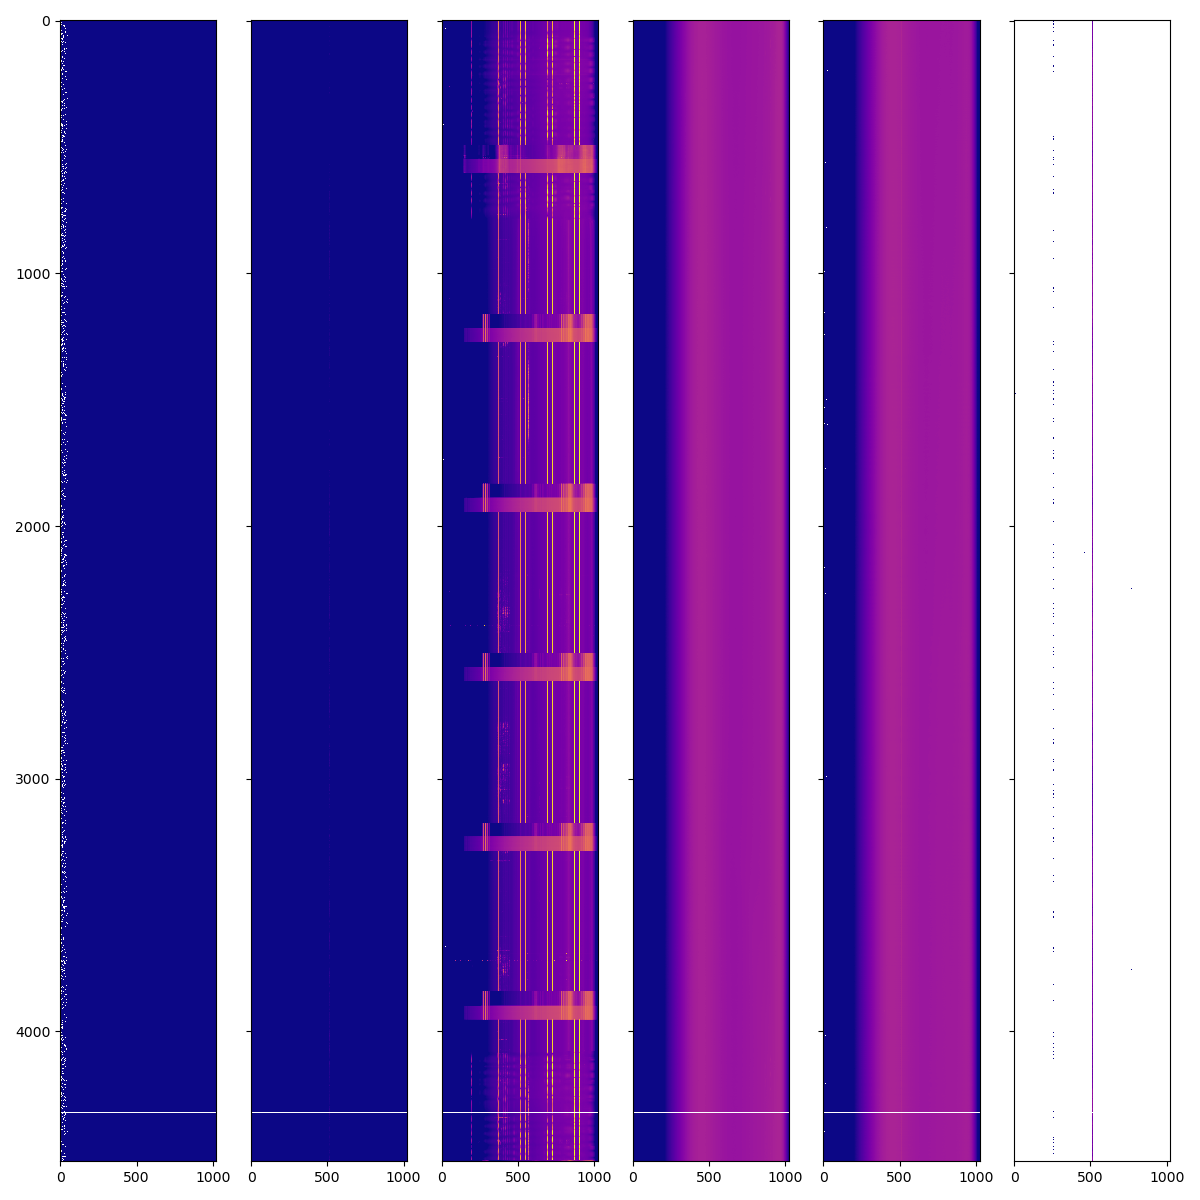

In [8]:
fig, axes = plt.subplots(ncols=len(ants), sharex=True, sharey=True, figsize=(12, 12))

for cnt, k in enumerate(ants):
    imshow(axes[cnt], something_data[k], vmax=8, vmin=5)
plt.tight_layout()
None

/tmp/ipykernel_65954/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


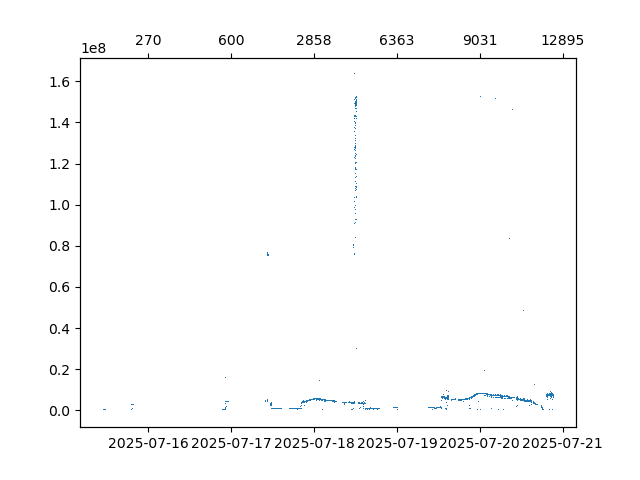

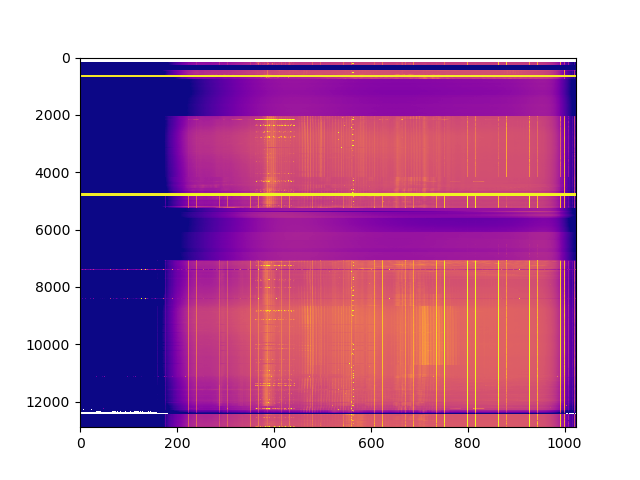

In [9]:
import matplotlib.dates as mdates
k = '3'
npz = np.load(f'all_ant_{k}.npz', allow_pickle=True)
d = npz[k][::16]
fig, ax1 = plt.subplots()
#imshow(plt.gca(), d, vmax=8, vmin=5)
dates = npz['local_times'][::16]
dates_num = mdates.date2num(dates)
ax1.plot(dates, d[:, 575], ',')
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

def sync_ticks(event=None):
    ticks = ax1.get_xticks()  # in date-number units
    idxs = np.searchsorted(dates_num, ticks)
    idxs = np.clip(idxs, 0, len(dates_num)-1)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels([str(i) for i in idxs])

fig.canvas.mpl_connect("draw_event", sync_ticks)
sync_ticks()

plt.figure()
imshow(plt.gca(), d, vmax=8, vmin=5)
None

In [23]:
t = noise_dropout_times[7][0]
i = np.searchsorted(times, t)
print(local_times[i])

2025-07-20 03:15:20.738519-06:00


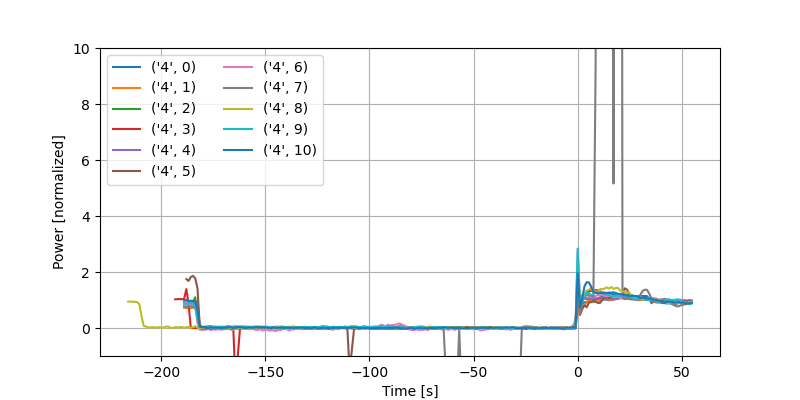

In [17]:
fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(8,4))
axes = [axes]
ch = 575
i_start, i_end = 4, -52
sl_on = slice(-30, None)
sl_baseline = slice(-74, -54)
ants = '0234'
for k in ants:
    for cnt, (_times, _d) in enumerate(zip(noise_dropout_times, noise_dropout_data[k])):
        if cnt >= 6 and k == '0':
            continue
        _P_bl = np.mean(_d[sl_baseline, ch])
        if np.any(_d[sl_on, ch] < _P_bl):
            norm = np.mean(_d[:i_start, ch]) - _P_bl
        else:
            norm = np.mean(_d[sl_on, ch]) - _P_bl
        axes[0].plot(_times - _times[i_end], (_d[:, ch] - _P_bl) / norm, label=str((k, cnt)))
for ax in axes:
    ax.set_ylim(-1, 10)
    ax.grid()
    ax.set_ylabel('Power [normalized]')
    #ax.set_xlim(-20, 20)
    ax.legend(ncols=2)
_ = axes[-1].set_xlabel('Time [s]')

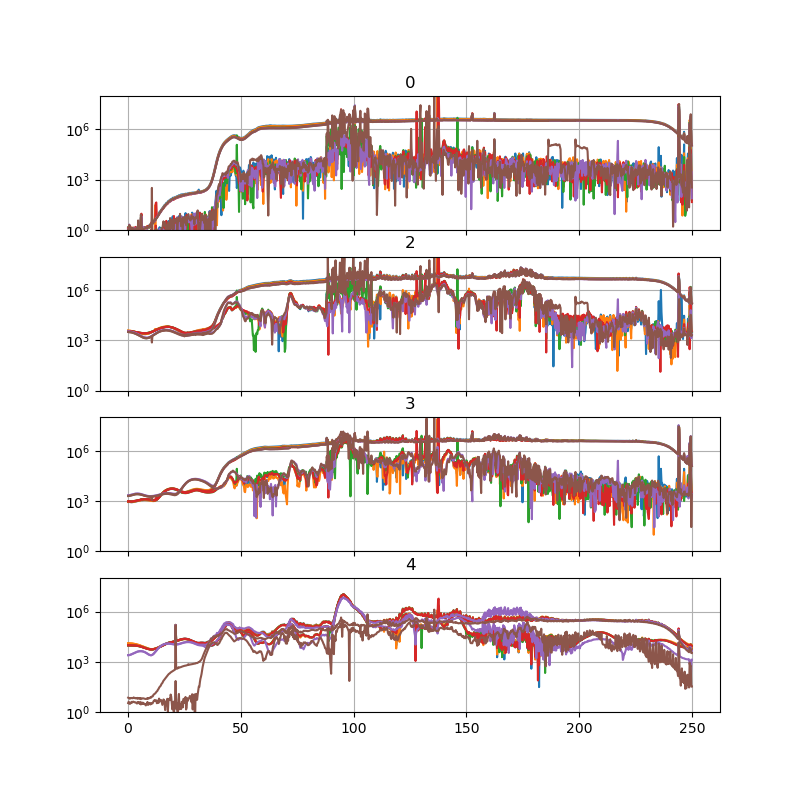

In [14]:
fig, axes = plt.subplots(nrows=len(ants), sharex=True, figsize=(8, 2 * len(ants)))
#i_on, i_off = -52, -54
i_on, i_off = 0, 8
#axes = [axes]
non_tx_chs = np.arange(freqs.size)
non_tx_chs = non_tx_chs[non_tx_chs % 16 != 0]
x = freqs[non_tx_chs]
for i, k in enumerate(ants):
    ax = axes[i]
    for cnt, (_times, _d) in enumerate(zip(noise_dropout_times, noise_dropout_data[k])):
        if k == '0' and cnt >= 6:
            continue
        elif cnt == 12:
            continue
        elif cnt >= 6: continue
        _d = _d[:, non_tx_chs]
        _P_on = np.mean(_d[sl_on], axis=0)
        _P_bl = np.mean(_d[sl_baseline], axis=0)
        line, = ax.semilogy(x, _P_on)
        #ax.semilogy(x, _P_bl, ':', color=line.get_color())
        ax.semilogy(x, np.abs(_P_on - _P_bl), color=line.get_color())
    ax.set_ylim(1e0, 1e8)
    ax.grid()
    ax.set_title(str(k))

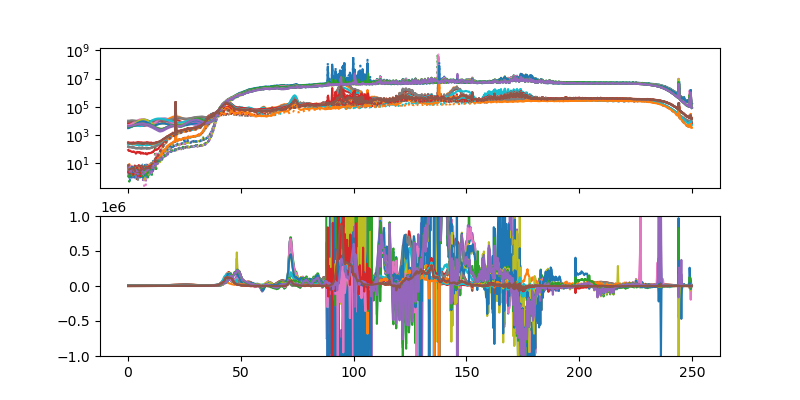

In [15]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,4))
i_on, i_off = -52, -54
#i_on, i_off = 0, 8
#axes = [axes]
non_tx_chs = np.arange(freqs.size)
non_tx_chs = non_tx_chs[non_tx_chs % 16 != 0]
for _times, _d2, _d4 in zip(noise_dropout_times[:13], noise_dropout_data['2'], noise_dropout_data['4']):
    x = freqs[non_tx_chs]
    for _d in [_d2, _d4]:
        _P_bl = np.mean(_d[sl_baseline], axis=0)
        line, = axes[0].semilogy(x, _d[i_on][non_tx_chs])
        axes[0].semilogy(x, _d[i_off][non_tx_chs], ':', color=line.get_color())
        if np.any(_d[sl_on, ch] < _P_bl[ch]):
            _P_on = np.mean(_d[:i_start], axis=0)
        else:
            _P_on = np.mean(_d[sl_on], axis=0)
        axes[1].plot(x, _P_on[non_tx_chs] - _P_bl[non_tx_chs], color=line.get_color())
_ = axes[1].set_ylim(-1e6, 1e6)

/tmp/ipykernel_5030/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


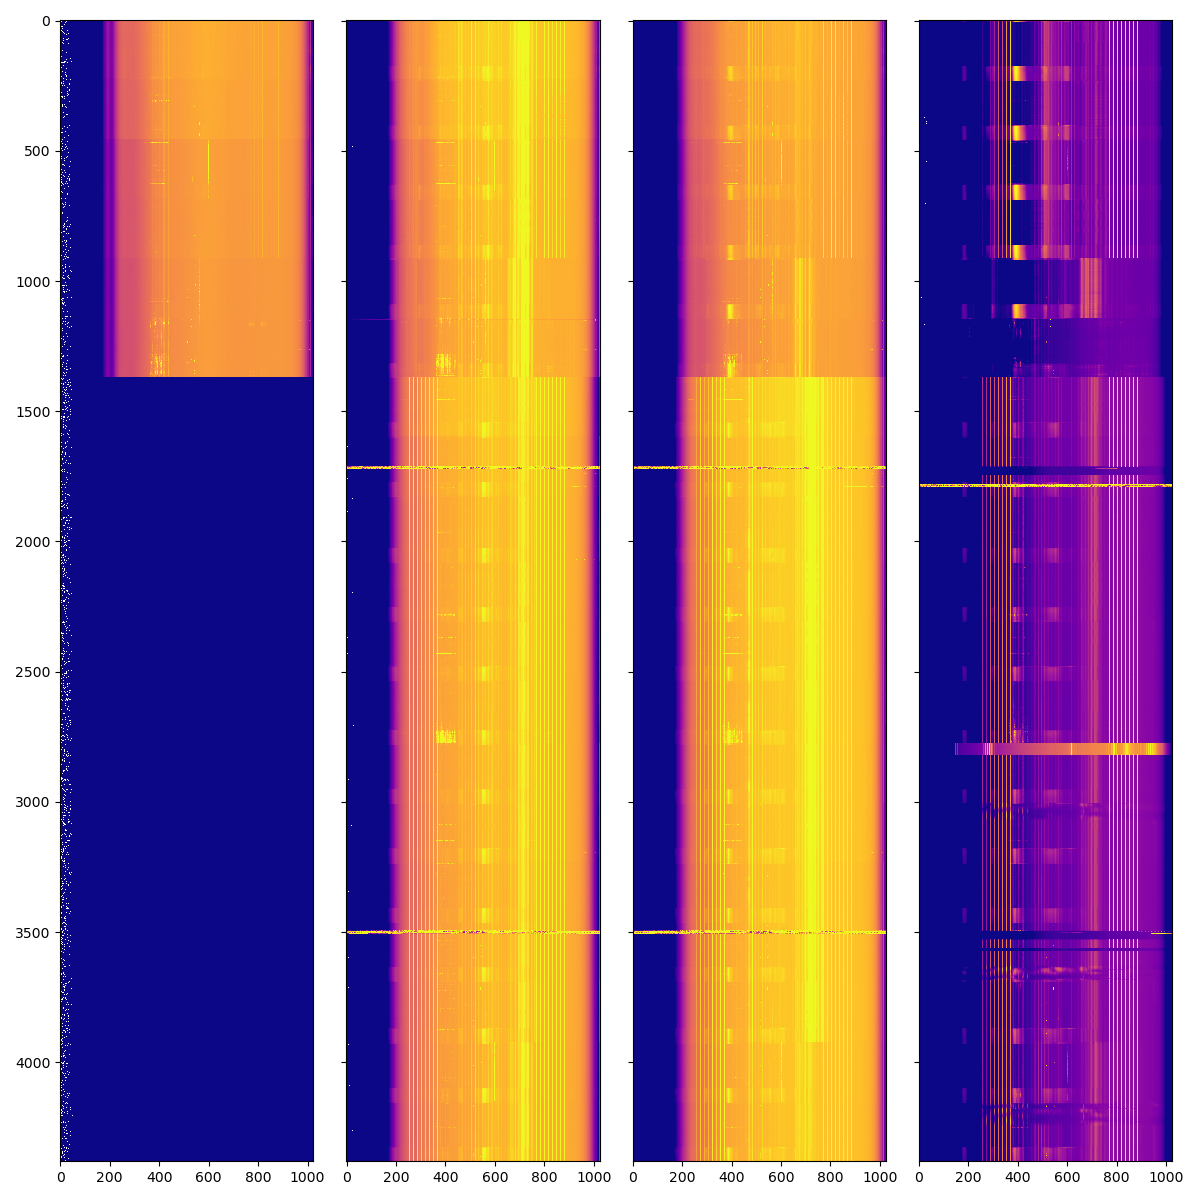

In [16]:
fig, axes = plt.subplots(ncols=len(ants), sharex=True, sharey=True, figsize=(12, 12))

for cnt, k in enumerate(ants):
    imshow(axes[cnt], np.concatenate(noise_dropout_data[k], axis=0), vmax=7, vmin=5)
plt.tight_layout()
None

In [17]:
more_dropout_times = [
 (1752849929 - 1800, 1752849929 + 639),
]
more_dropout_slices = [slice(np.searchsorted(times, t_i), np.searchsorted(times, t_j)+1) for (t_i, t_j) in more_dropout_times]
more_dropout_times = [times[sl] for sl in more_dropout_slices]
more_dropout_local_times = [local_times[sl] for sl in more_dropout_slices]

In [18]:
more_dropout_local_times[0][0], more_dropout_local_times[0][-1]

(datetime.datetime(2025, 7, 18, 8, 15, 29, 525960, tzinfo=zoneinfo.ZoneInfo(key='America/Denver')),
 datetime.datetime(2025, 7, 18, 8, 56, 9, 67384, tzinfo=zoneinfo.ZoneInfo(key='America/Denver')))

In [19]:
more_dropout_data = {}
for npz_file in npz_files:
    npz = np.load(npz_file, allow_pickle=True)
    freqs = npz['freqs']
    d = {k: npz[k] for k in npz.files if len(k) == 1}
    more_dropout_data.update({k: [v[sl] for sl in more_dropout_slices] for k, v in d.items()})
d2, d4 = more_dropout_data.pop('2'), more_dropout_data.pop('4')
more_dropout_data['2'] = d2[:6] + d4[6:] # swap ground & sky antenna
more_dropout_data['4'] = d4[:6] + d2[6:] # swap ground & sky antenna

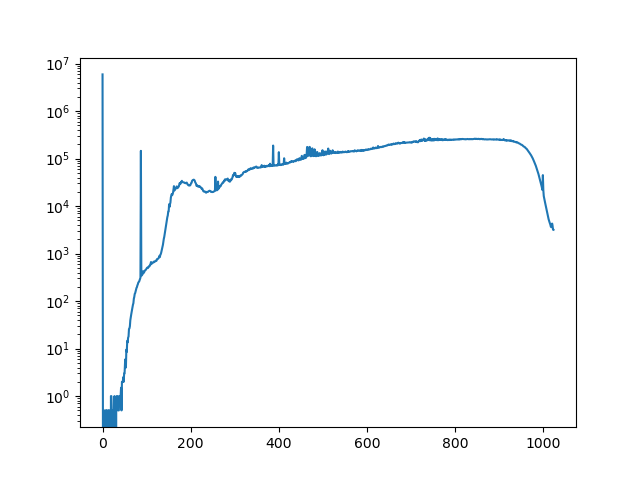

In [20]:
plt.figure()
P_avg = np.min(more_dropout_data['4'][0][1750:1846], axis=0)
#_ = plt.semilogy(np.abs(more_dropout_data['4'][0][1750:1846] - P_avg).T)
_ = plt.semilogy(P_avg)

In [21]:
dP = more_dropout_data['4'][0][1750:1846] - P_avg
U, S, Vt = np.linalg.svd(dP, full_matrices=False)
neig = 25
dP_mdl = np.einsum('te,e,ef->tf', U[:,:neig], S[:neig], Vt[:neig])

/tmp/ipykernel_5030/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


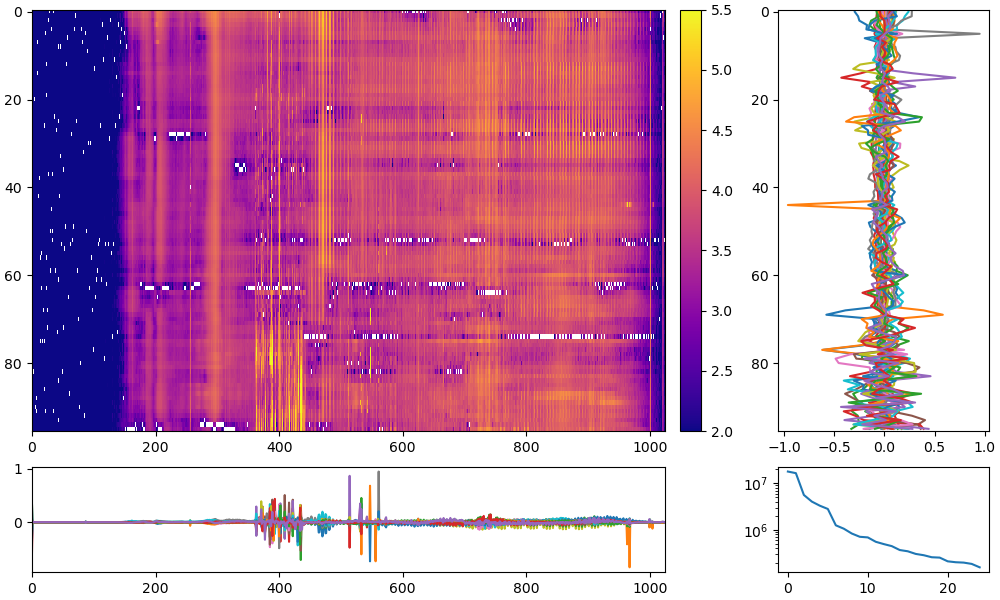

In [22]:
plot_time_freq_layout(dP - 0*dP_mdl, U, Vt, S, neig=neig, cmap="plasma", vmin=2, vmax=5.5, figsize=(10, 6))

In [80]:
kur_U = np.sum(np.abs(U )**4, axis=0)
kur_V = np.sum(np.abs(Vt)**4, axis=1)
i_t = np.where(kur_V > 1e-1)[0]

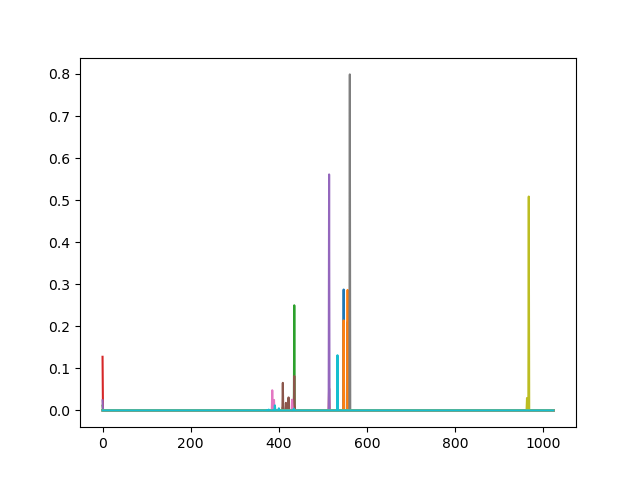

In [81]:
plt.figure()
#plt.plot(np.sum(np.abs(Vt)**4, axis=1))
#for i in i_t:
    #plt.plot(np.abs(U[:,i])**4)
    #plt.plot(np.abs(Vt[i])**4)

/tmp/ipykernel_83917/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


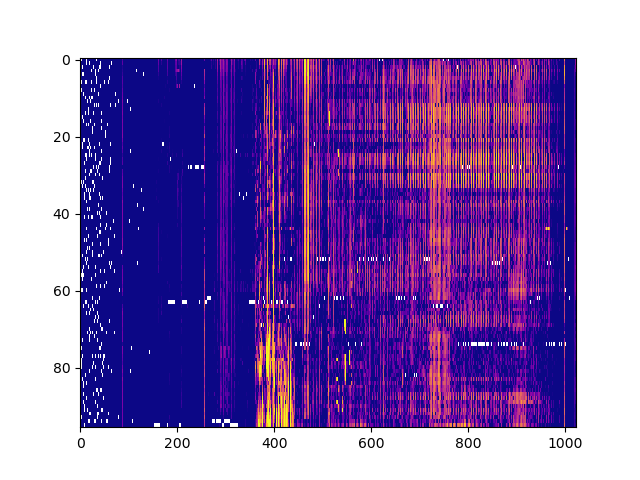

In [60]:
plt.figure()
imshow(plt.gca(), np.diff(dP), vmax=5, vmin=3)

/tmp/ipykernel_83917/3597281131.py:3: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.abs(data))


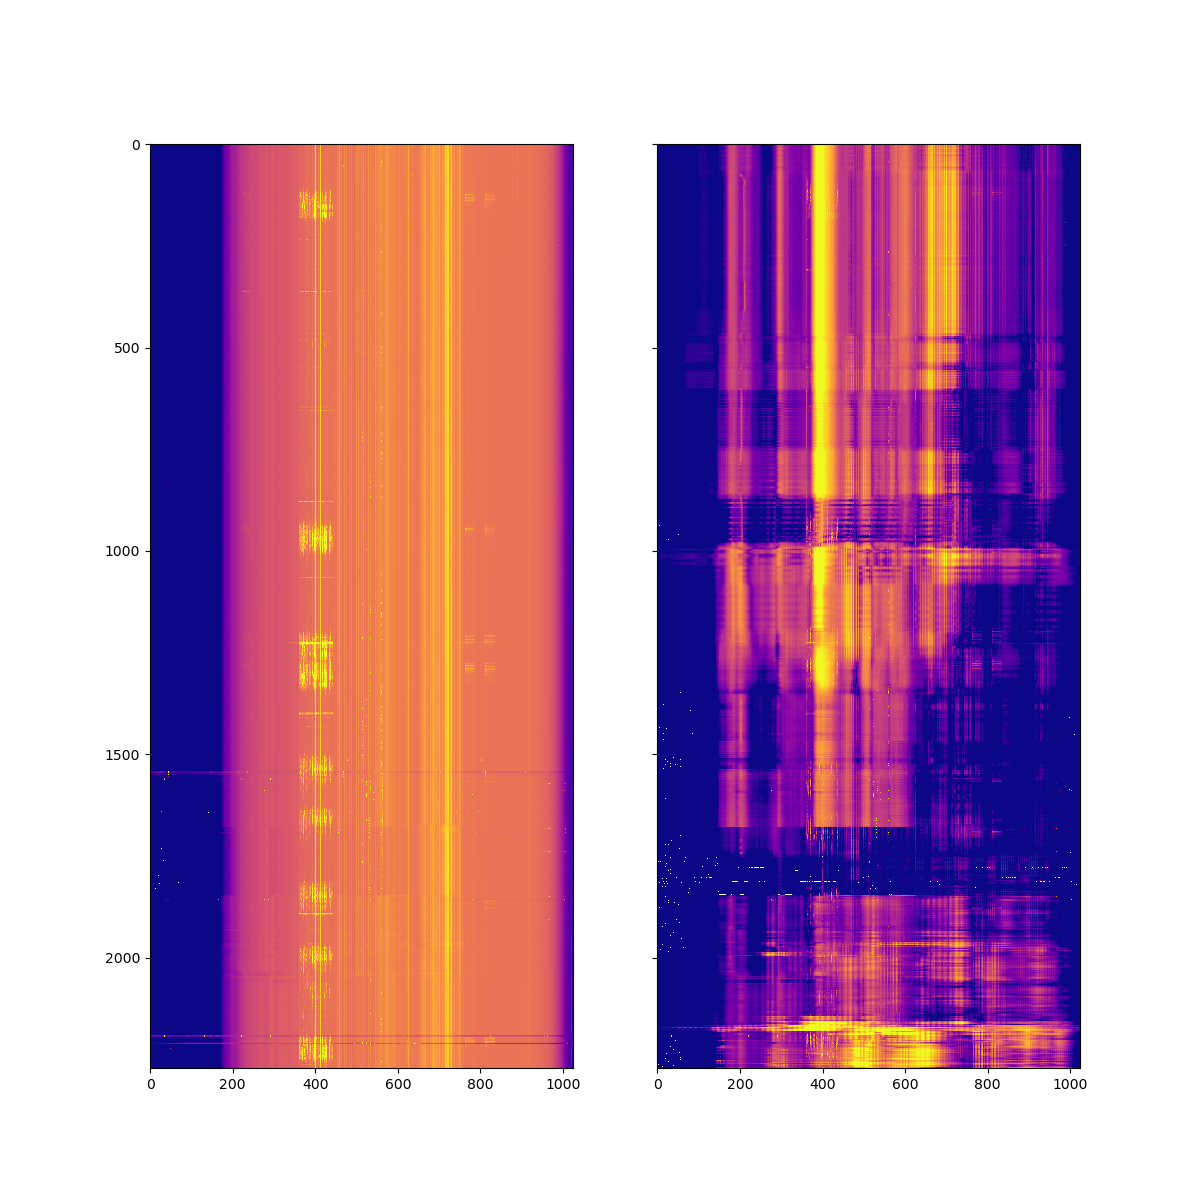

In [36]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 12))

imshow(axes[0], np.concatenate(more_dropout_data['2'] - P_avg, axis=0), vmax=7.5, vmin=5)
imshow(axes[1], np.concatenate(more_dropout_data['4'] - P_avg, axis=0), vmax=6.5, vmin=4)
None